In [1]:
from window import *
import rotB

if __name__ == "__main__":
    dim = (32,32,64)
    
    idx = np.indices(dim).astype(np.float32)  
    X = np.zeros(dim+(4,), dtype = np.float32)
    X[:,:,:,0] = idx[0,:,:,:]
    X[:,:,:,1] = idx[1,:,:,:]
    X[:,:,:,2] = idx[2,:,:,:]

    X1 = np.array(X)
    ar = 10**2
    az = 16**2
    h = np.exp(-((X[:,:,:,0]-dim[0]/2)**2 + (X[:,:,:,1]-dim[1]/2)**2)/ar - (X[:,:,:,2]-dim[2]/2)**2/az)*np.pi*2

    X[:,:,:,2] -= dim[2]/2
    X[:,:,:,0] = ((X1[:,:,:,0]-dim[0]/2)*np.cos(h) - (X1[:,:,:,1]-dim[1]/2)*np.sin(h))#*(1.+np.cos(X[:,:,:,2]*np.pi/dim[2]))*0.5
    X[:,:,:,1] = ((X1[:,:,:,0]-dim[0]/2)*np.sin(h) + (X1[:,:,:,1]-dim[1]/2)*np.cos(h))#*(1.+np.cos(X[:,:,:,2]*np.pi/dim[2]))*0.5
                  #+ 16*np.cos(X[:,:,:,2]*np.pi/dim[2]))
    
    #X*= 0.015
    X[:,:,:,3] = 1.
    
    B = np.zeros(dim+(4,), dtype = np.float32)
    B[:,:,:,2] = np.ones(dim, dtype = np.float32)
    
    #X*=0.01
    
    #X = (np.random.random(dim+(4,)).astype(np.float32) - 0.5)*0.3
    cle = rotB.CL(X, B)
    cle.start()
    
    #window(cle, video_dir = '/video')


In [2]:
import matplotlib.pyplot as plt

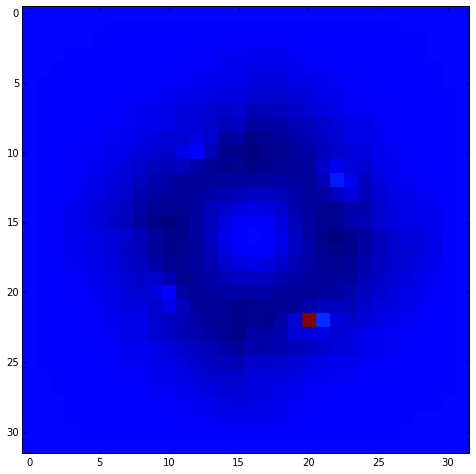

In [6]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.imshow(cle._X[:,:,32,2], interpolation = 'nearest')

In [5]:
np.max(cle._X[:,:,32,0])

nan